In [2]:
# ATLAS

import os
import pandas as pd

dir = "C:/Users/Miha Rupar/Desktop/Miha/Faks/2PZ/MPBF/ATLAS_data/ATLAS"

mol_n = len(os.listdir(dir))
atlas_data = {}

for mol_dir in os.listdir(dir):
    b_factor = plddt = rmsf = rmsf1 = rmsf2 = rmsf3 = gyr_R1 = gyr_R2 = gyr_R3 = None
    file_dir = f'{dir}/{mol_dir}/analysis'
    for file in os.listdir(file_dir):
        if file.endswith('Bfactor.tsv'):
            b_factor = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            b_factor = b_factor[['Bfactor']]
        elif file.endswith('pLDDT.tsv'):
            plddt = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            plddt = plddt[['pLDDT']]
        elif file.endswith('RMSF.tsv'):
            rmsf = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            rmsf1 = rmsf[['RMSF_R1']]
            rmsf2 = rmsf[['RMSF_R2']]
            rmsf3 = rmsf[['RMSF_R3']]
        elif file.endswith('gyrate.tsv'):
            gyr = pd.read_csv(f'{file_dir}/{file}', sep='\t')
            gyr_R1 = gyr[['gyr_R1']]
            gyr_R2 = gyr[['gyr_R2']]
            gyr_R3 = gyr[['gyr_R3']]
        else:
            continue
        
        df = pd.concat([b_factor, plddt, rmsf1, rmsf2, rmsf3], axis=1)

        corr_mat = df.corr(method='spearman')


    atlas_data[mol_dir] = {
        'b_factor': b_factor,
        'plddt': plddt,
        'rmsf': rmsf,
        'gyr_R1': gyr_R1,
        'gyr_R2': gyr_R2,
        'gyr_R3': gyr_R3,
        'corr_mat': corr_mat,
        'mol_len': len(b_factor)
    }


In [2]:
import matplotlib.pyplot as plt

corr_values = []
median_values = []
mean_values = []

for mol, data in atlas_data.items():
    corr = data['corr_mat']

    corr_values.append({
        'mol': mol,
        'Bfactor_pLDDT': corr.loc['Bfactor', 'pLDDT'],
        'Bfactor_RMSF_R1': corr.loc['Bfactor', 'RMSF_R1'],
        'Bfactor_RMSF_R2': corr.loc['Bfactor', 'RMSF_R2'],
        'Bfactor_RMSF_R3': corr.loc['Bfactor', 'RMSF_R3'],
        'pLDDT_RMSF_R1': corr.loc['pLDDT', 'RMSF_R1'],
        'pLDDT_RMSF_R2': corr.loc['pLDDT', 'RMSF_R2'],
        'pLDDT_RMSF_R3': corr.loc['pLDDT', 'RMSF_R3'],
    })
    
    median_values.append({
        'mol': mol,
        'gyr_R1_median': data['gyr_R1'].median().iloc[0],
        'gyr_R2_median': data['gyr_R2'].median().iloc[0],
        'gyr_R3_median': data['gyr_R3'].median().iloc[0],
        'plDDT_median': data['plddt'].median().iloc[0],
        'Bfactor_median': data['b_factor'].median().iloc[0],
        'RMSF_R1_median': data['rmsf']['RMSF_R1'].median(),
        'RMSF_R2_median': data['rmsf']['RMSF_R2'].median(),
        'RMSF_R3_median': data['rmsf']['RMSF_R3'].median(),
    })

    mean_values.append({
        'mol': mol,
        'gyr_R1_mean': data['gyr_R1'].mean().iloc[0],
        'gyr_R2_mean': data['gyr_R2'].mean().iloc[0],
        'gyr_R3_mean': data['gyr_R3'].mean().iloc[0],
        'plDDT_mean': data['plddt'].mean().iloc[0],
        'Bfactor_mean': data['b_factor'].mean().iloc[0],
        'RMSF_R1_mean': data['rmsf']['RMSF_R1'].mean(),
        'RMSF_R2_mean': data['rmsf']['RMSF_R2'].mean(),
        'RMSF_R3_mean': data['rmsf']['RMSF_R3'].mean(),
    })

corr_df = pd.DataFrame(corr_values)

In [4]:
median_df = pd.DataFrame(median_values)
mean_df = pd.DataFrame(mean_values)

corr_median = median_df.drop(columns=["mol"]).corr(method="spearman")
corr_mean = mean_df.drop(columns=["mol"]).corr(method="spearman")

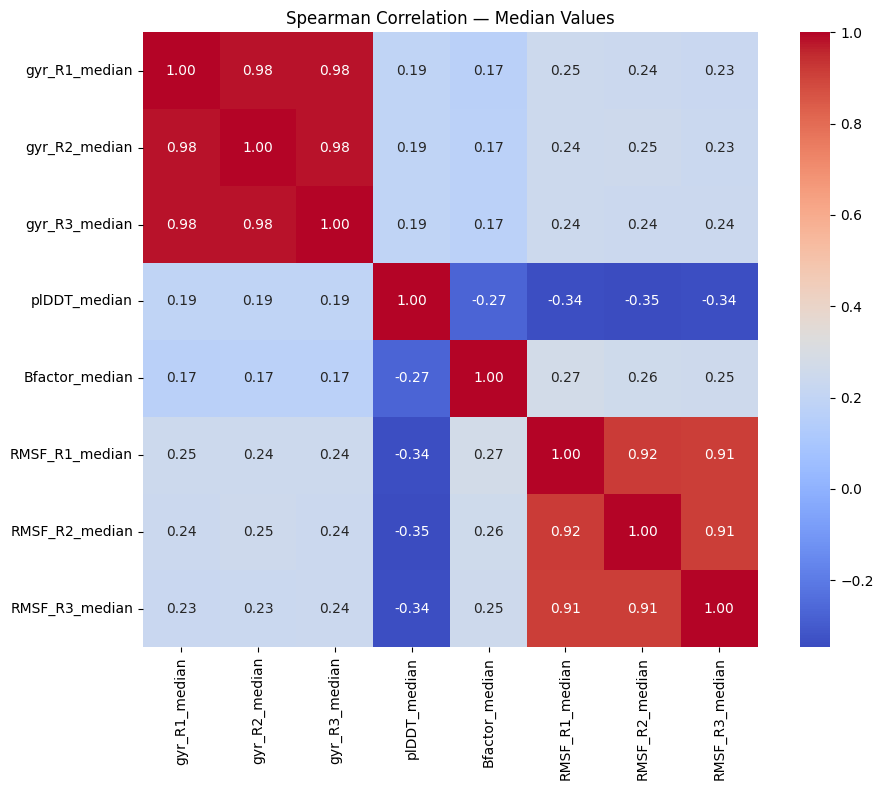

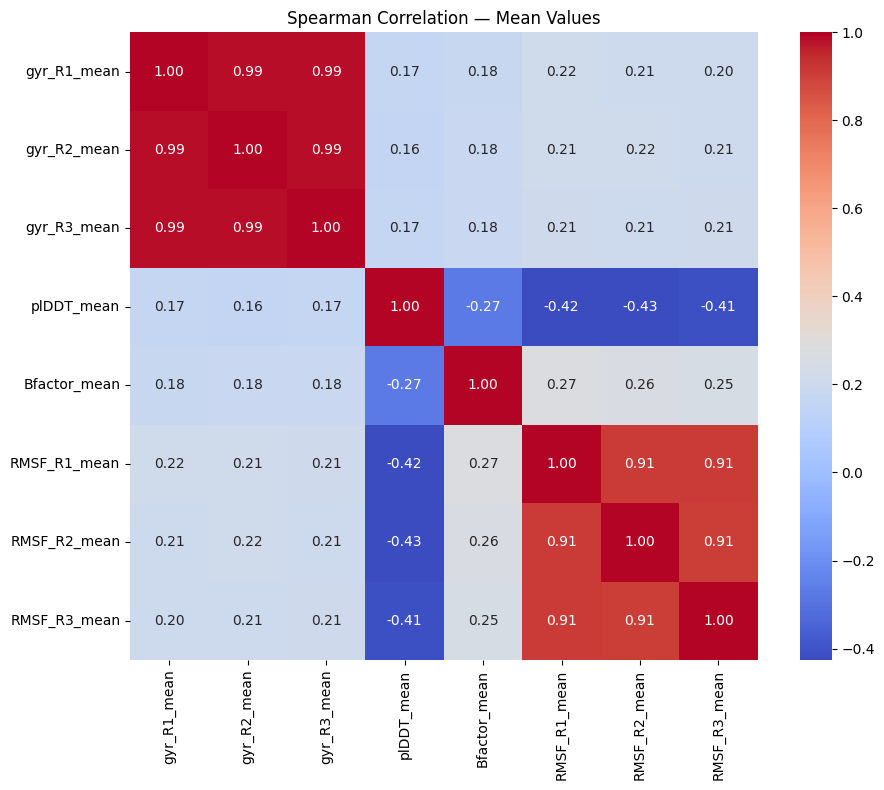

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- MEDIAN CORRELATION ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_median, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman Correlation — Median Values")
plt.tight_layout()
plt.show()

# --- MEAN CORRELATION ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mean, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Spearman Correlation — Mean Values")
plt.tight_layout()
plt.show()


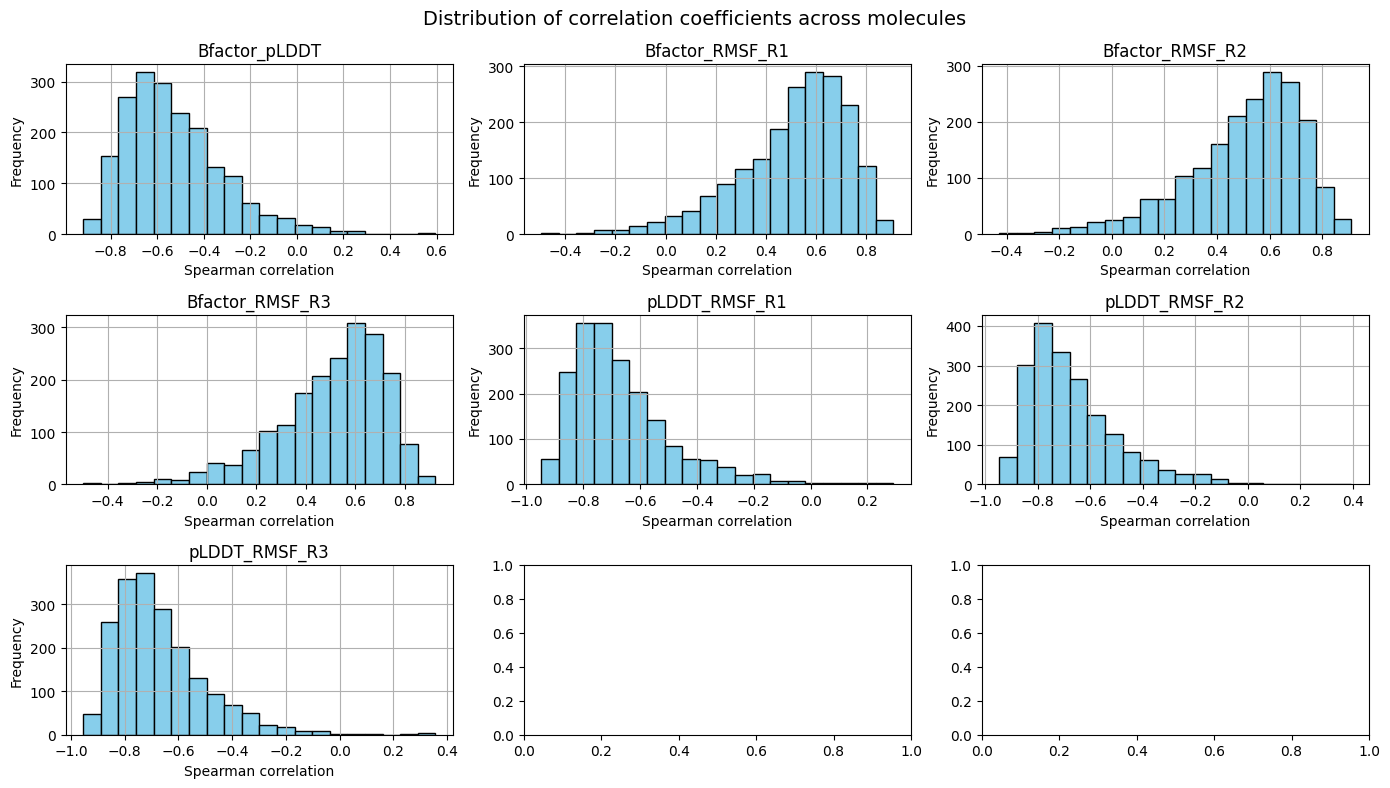

In [ ]:
# Plot histograms for correlation distributions
fig, axes = plt.subplots(3, 3, figsize=(14, 8))

# Select only numeric columns (skip 'mol')
numeric_cols = corr_df.select_dtypes(include='number').columns

for ax, col in zip(axes.ravel(), numeric_cols):
    ax.hist(corr_df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Spearman correlation')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.suptitle('Distribution of correlation coefficients across molecules', fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt

# Collect correlation + molecule length info
summary_data = []

for mol, data in atlas_data.items():
    corr = data['corr_mat']
    mol_len = data['mol_len']
    try:
        summary_data.append({
            'mol': mol,
            'mol_len': mol_len,
            'pLDDT_RMSF_R1': corr.loc['pLDDT', 'RMSF_R1'],
            'pLDDT_RMSF_R2': corr.loc['pLDDT', 'RMSF_R2'],
            'pLDDT_RMSF_R3': corr.loc['pLDDT', 'RMSF_R3']
        })
    except KeyError:
        # skip incomplete correlations
        continue

summary_df = pd.DataFrame(summary_data)
print(summary_df.head())


      mol  mol_len  pLDDT_RMSF_R1  pLDDT_RMSF_R2  pLDDT_RMSF_R3
0  16pk_A      415      -0.489522      -0.474107      -0.371741
1  1a62_A      130      -0.803851      -0.703783      -0.647406
2  1ab1_A       46      -0.759919      -0.835755      -0.808443
3  1af7_A      274      -0.596054      -0.632525      -0.597743
4  1ah7_A      245      -0.638981      -0.778295      -0.634399


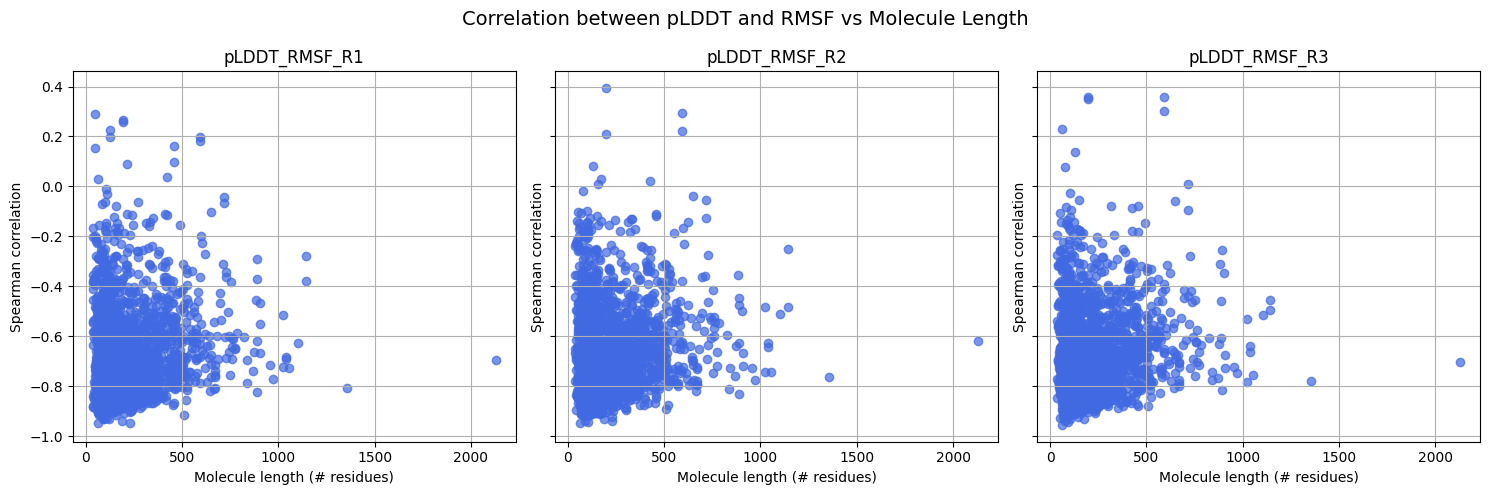

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, col in enumerate(['pLDDT_RMSF_R1', 'pLDDT_RMSF_R2', 'pLDDT_RMSF_R3']):
    axes[i].scatter(summary_df['mol_len'], summary_df[col], color='royalblue', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Molecule length (# residues)')
    axes[i].set_ylabel('Spearman correlation')
    axes[i].grid(True)

plt.suptitle('Correlation between pLDDT and RMSF vs Molecule Length', fontsize=14)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
scope = pd.read_csv('mol_scope.csv', sep=';', usecols=[0,1])
scope.iloc[:, 0] = scope.iloc[:, 0].str.replace(r'(.)$', r'_\1', regex=True)
multi_domain = scope[scope.iloc[:, 1].str.contains(' ', na=False)]
multi_domain.columns = ['mol', 'domains']
multi_domain

atlas_multi_domain = pd.read_csv('ATLAS.csv', header=0, sep=',')
atlas_multi_domain = atlas_multi_domain[['PDB', 'SCOPe ID', 'CATH ID']]
atlas_multi_domain = atlas_multi_domain[atlas_multi_domain.iloc[:, 1].str.contains(' ', na=False)]
atlas_multi_domain = atlas_multi_domain[atlas_multi_domain.iloc[:, 2].str.contains(' ', na=False)]
atlas_multi_domain['PDB'] = atlas_multi_domain['PDB'].str.replace(r'(.)$', r'_\1', regex=True)
atlas_multi_domain

,PDB,SCOPe ID,CATH ID
1,1a62_A,a.140.3.1 b.40.4.5,1.10.720.10 2.40.50.140
3,1af7_A,a.58.1.1 c.66.1.8,1.10.155.10 3.40.50.150
8,1b25_D,a.110.1.1 d.152.1.1,1.10.569.10 1.10.599.10 3.60.9.10
22,1c96_A,c.8.2.1 c.83.1.1,3.20.19.10 3.30.499.10 3.30.499.10 3.40.1060.10
29,1cvr_A,b.1.18.12 c.17.1.2,2.60.40.10 3.40.50.1460 3.40.50.10390
...,...,...,...
1643,5osw_A,a.126.1.0 a.126.1.0 a.126.1.0,1.10.246.10 1.10.246.10 1.10.246.10 1.10.246.1...
1688,5y4z_A,c.37.1.14 c.37.1.0,3.40.50.300 3.40.50.300
1700,6a0p_A,b.1.18.0 f.10.1.0,2.60.40.350 2.60.98.10 3.30.67.10 3.30.387.10
1733,6e5y_A,c.26.2.0 d.210.1.1,1.10.287.400 3.40.50.620 3.90.1260.10


1lslA: https://scop.berkeley.edu/sunid=82897
1skzA: https://scop.berkeley.edu/sunid=57268
2fj8A: https://scop.berkeley.edu/sunid=254905

In [19]:
import numpy as np
from scipy.stats import kruskal

test_results = {}
for i, row in atlas_multi_domain.iterrows():
    n_scope_domains = row['SCOPe ID'].count(' ') + 1
    n_cath_domains = row['CATH ID'].count(' ') + 1
    if n_scope_domains != n_cath_domains:
        continue
    if n_scope_domains != 2:
        continue
    
    mol = row["PDB"]
    mol_len = atlas_data[mol]['mol_len']
    if mol_len < 100:
        continue
    lrmsf1 = []
    rmsf1 = atlas_data[mol]['rmsf']['RMSF_R1']
    for val in rmsf1:
        new_val = np.log(val + 1)
        lrmsf1.append(new_val)
    lrmsf2 = []
    rmsf2 = atlas_data[mol]['rmsf']['RMSF_R2']
    for val in rmsf2:
        new_val = np.log(val + 1)
        lrmsf2.append(new_val)
    lrmsf3 = []
    rmsf3 = atlas_data[mol]['rmsf']['RMSF_R3']
    for val in rmsf3:
        new_val = np.log(val + 1)
        lrmsf3.append(new_val)

    rmsf1 = lrmsf1
    rmsf2 = lrmsf2
    rmsf3 = lrmsf3

    start = int(0.05 * mol_len)
    end = int(0.95 * mol_len)

    # Trim arrays
    rmsf1_trimmed = rmsf1[start:end]
    rmsf2_trimmed = rmsf2[start:end]
    rmsf3_trimmed = rmsf3[start:end]

    rmsf1_split = np.array_split(rmsf1_trimmed, n_scope_domains)
    rmsf2_split = np.array_split(rmsf2_trimmed, n_scope_domains)
    rmsf3_split = np.array_split(rmsf3_trimmed, n_scope_domains)

    pvalues = {}
    for name, rmsf_splits in {"R1": rmsf1_split, "R2": rmsf2_split, "R3": rmsf3_split}.items():
        stat, p = kruskal(*rmsf_splits)
        if p < 0.05:
            pvalues[f'RMSF_{name}_pvalue'] = p
        else:
            break
    else:
        test_results[mol] = {
        'mol_len': atlas_data[mol]['mol_len'],
        'n_domains': n_scope_domains,
        **pvalues
    }
        
test_results


{'1dzf_A': {'mol_len': 215,
  'n_domains': 2,
  'RMSF_R1_pvalue': np.float64(1.2962076240557126e-09),
  'RMSF_R2_pvalue': np.float64(1.4945416021917093e-09),
  'RMSF_R3_pvalue': np.float64(6.281990472744005e-07)},
 '1f5n_A': {'mol_len': 592,
  'n_domains': 2,
  'RMSF_R1_pvalue': np.float64(5.01275034113862e-13),
  'RMSF_R2_pvalue': np.float64(2.991863163274003e-13),
  'RMSF_R3_pvalue': np.float64(8.029486364286826e-26)},
 '1hw1_B': {'mol_len': 239,
  'n_domains': 2,
  'RMSF_R1_pvalue': np.float64(9.221373150177836e-06),
  'RMSF_R2_pvalue': np.float64(4.874851060262906e-07),
  'RMSF_R3_pvalue': np.float64(0.0001229965553102899)},
 '1hye_A': {'mol_len': 313,
  'n_domains': 2,
  'RMSF_R1_pvalue': np.float64(1.0639199041323645e-13),
  'RMSF_R2_pvalue': np.float64(2.110361528994407e-08),
  'RMSF_R3_pvalue': np.float64(4.301108374830726e-09)},
 '1k5n_A': {'mol_len': 276,
  'n_domains': 2,
  'RMSF_R1_pvalue': np.float64(1.0617452532855796e-14),
  'RMSF_R2_pvalue': np.float64(0.002602628319924

In [ ]:
res = {}

mol = '1c96_A'  
mol_len = atlas_data[mol]['mol_len']
n_domains = 2  # set manually for this example

lrmsf1 = []
rmsf1 = atlas_data[mol]['rmsf']['RMSF_R1']
for val in rmsf1:
    new_val = np.log(val + 1)
    lrmsf1.append(new_val)
lrmsf2 = [] 
rmsf2 = atlas_data[mol]['rmsf']['RMSF_R2']
for val in rmsf2:
    new_val = np.log(val + 1)
    lrmsf2.append(new_val)
lrmsf3 = []
rmsf3 = atlas_data[mol]['rmsf']['RMSF_R3']
for val in rmsf3:
    new_val = np.log(val + 1)
    lrmsf3.append(new_val)

start = int(0.05 * mol_len)
end = int(0.95 * mol_len)
# Trim arrays
rmsf1_trimmed = lrmsf1[start:end]
rmsf2_trimmed = lrmsf2[start:end]
rmsf3_trimmed = lrmsf3[start:end]

# Split RMSF into domains
rmsf1_split = np.array_split(rmsf1_trimmed, n_domains)
rmsf2_split = np.array_split(rmsf2_trimmed, n_domains)
rmsf3_split = np.array_split(rmsf3_trimmed, n_domains)

pvalues = {}
for name, rmsf_splits in {"R1": rmsf1_split, "R2": rmsf2_split, "R3": rmsf3_split}.items():
    stat, p = kruskal(*rmsf_splits)
    if p < 0.05:
        pvalues[f'RMSF_{name}_pvalue'] = p
    else:
        break 
else:
    res[mol] = {
        'mol_len': atlas_data[mol]['mol_len'],
        'n_domains': n_domains,
        **pvalues
    }

res

{'1c96_A': {'mol_len': 753,
  'n_domains': 2,
  'RMSF_R1_pvalue': np.float64(3.2904918917244133e-84),
  'RMSF_R2_pvalue': np.float64(4.687711253619639e-39),
  'RMSF_R3_pvalue': np.float64(2.3820211265299097e-30)}}

(array([ 3.,  1.,  1.,  0.,  0.,  0.,  5.,  2.,  1.,  6., 11., 16., 18.,
        20., 24., 17., 26., 18., 21., 21., 20., 28., 14., 15.,  8., 11.,
        10., 14., 10.,  7., 12.,  8.,  4.,  0.,  1.,  1.,  2.,  3.,  1.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.083  , 0.09016, 0.09732, 0.10448, 0.11164, 0.1188 , 0.12596,
        0.13312, 0.14028, 0.14744, 0.1546 , 0.16176, 0.16892, 0.17608,
        0.18324, 0.1904 , 0.19756, 0.20472, 0.21188, 0.21904, 0.2262 ,
        0.23336, 0.24052, 0.24768, 0.25484, 0.262  , 0.26916, 0.27632,
        0.28348, 0.29064, 0.2978 , 0.30496, 0.31212, 0.31928, 0.32644,
        0.3336 , 0.34076, 0.34792, 0.35508, 0.36224, 0.3694 , 0.37656,
        0.38372, 0.39088, 0.39804, 0.4052 , 0.41236, 0.41952, 0.42668,
        0.43384, 0.441  ]),
 <BarContainer object of 50 artists>)

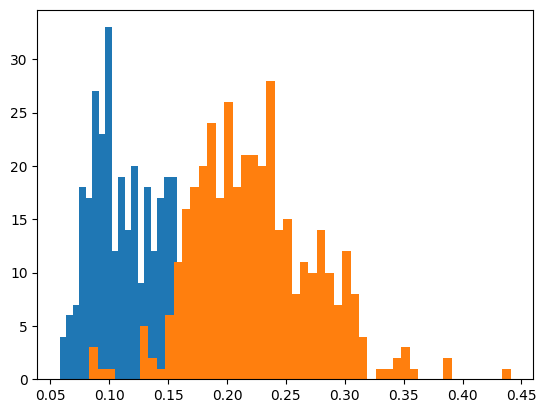

In [ ]:
import matplotlib.pyplot as plt

plt.hist(atlas_data['1c96_A']['rmsf']['RMSF_R1'][:370], bins=50)
plt.hist(atlas_data['1c96_A']['rmsf']['RMSF_R1'][370:], bins=50)